Data is from the following https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

metric to maximize is f1_score 


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.preprocessing as pre
import sklearn.linear_model as lin
import sklearn.model_selection as mod
import sklearn.metrics as met
import sklearn.pipeline as pip
import sklearn.tree as tree
import sklearn.ensemble as ens
import seaborn as sns
from sklearn import cluster as clu
import sklearn.compose as cmp
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from imblearn import over_sampling as ove
from imblearn import under_sampling as und
from imblearn import combine as com
from imblearn import pipeline as imbPipe
import matplotlib.cbook
from sklearn.model_selection import learning_curve


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df = pd.read_excel("default of credit card clients.xls",header=1)

df = pd.read_excel("/content/drive/MyDrive/default of credit card clients.xls",header=1)
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [ ]:
pd.concat([df.describe(include="all").T,(round(100*(df.isnull().sum()/len(df.index)), 2)).rename('missing_ratio')], axis=1)

,count,mean,std,min,25%,50%,75%,max,missing_ratio
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0,0.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0,0.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0,0.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0,0.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0,0.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0,0.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0,0.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0,0.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0,0.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0,0.0


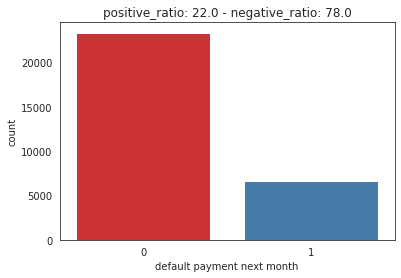

In [ ]:
positive_ratio    = (str(round(df[df["default payment next month"] == 1]["default payment next month"].count()/df["default payment next month"].count(),2)*100))
negative_ratio = (str(round(df[df["default payment next month"] == 0]["default payment next month"].count()/df["default payment next month"].count(),2)*100))
sns.set_style("white")
sns.countplot(x='default payment next month', data=df, palette="Set1")
plt.title("positive_ratio: "+ positive_ratio + " - negative_ratio: " + negative_ratio )
plt.show()


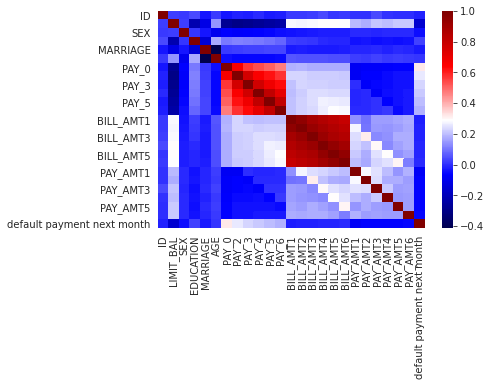

In [ ]:
sns.heatmap(df.corr(), cmap='seismic');

BILL AMT and PAY features have high correlation. I will keep them in the first place. However, I may need to remove them.

Hence, in case of an info loss, I will calculate percentage change for the related columns. For example Pay 0 and pay 2 represent the same info for different months. Percentage change can be a good way to keep the information.


In [6]:
df_Pay = df[["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)
df_Pay = df_Pay[["PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]].rename(columns={"PAY_2":"PAY_0_2", "PAY_3":"PAY_2_3", "PAY_4":"PAY_3_4", "PAY_5":"PAY_4_5","PAY_6":"PAY_5_6"})
df = pd.concat((df,df_Pay),axis=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY_0_2,PAY_2_3,PAY_3_4,PAY_4_5,PAY_5_6
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.0,-1.5,0.0,1.0,0.0
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-3.0,-1.0,0.0,0.0,0.0
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.0,0.0,0.0,0.0,0.0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.0,0.0,0.0,0.0,0.0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-1.0,0.0,-1.0,0.0,0.0


In [7]:
df_bill = df[["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)
df_bill = df_bill[["BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]].rename(columns={"BILL_AMT2":"BILL_AMT1_2", "BILL_AMT3":"BILL_AMT_2_3", "BILL_AMT4":"BILL_AMT_3_4", "BILL_AMT5":"BILL_AMT4_5","BILL_AMT6":"BILL_AMT_5_6"})
df = pd.concat((df,df_bill),axis=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY_0_2,PAY_2_3,PAY_3_4,PAY_4_5,PAY_5_6,BILL_AMT1_2,BILL_AMT_2_3,BILL_AMT_3_4,BILL_AMT4_5,BILL_AMT_5_6
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.0,-1.5,0.0,1.0,0.0,-0.207258,-0.777885,-1.000000,0.000000,0.000000
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-3.0,-1.0,0.0,0.0,0.0,-0.356823,0.554783,0.219985,0.055929,-0.056151
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.0,0.0,0.0,0.0,0.0,-0.520264,-0.033364,0.056936,0.043054,0.040206
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.0,0.0,0.0,0.0,0.0,0.026452,0.021935,-0.425575,0.022780,0.020305
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-1.0,0.0,-1.0,0.0,0.0,-0.341998,5.320106,-0.415655,-0.085673,-0.000783


In [8]:
df_pamt = df[["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)
df_pamt = df_pamt[["PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]].rename(columns={"PAY_AMT2":"PAY_AMTT1_2", "PAY_AMT3":"PAY_AMT_2_3", "PAY_AMT4":"PAY_AMT_3_4", "PAY_AMT5":"PAY_AMT4_5","PAY_AMT6":"PAY_AMT_5_6"})
df = pd.concat((df,df_pamt),axis=1)


In [9]:
df["PAY_AMT_1_6"]=df[["PAY_AMT1","PAY_AMT6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)["PAY_AMT6"]
df["BILL_AMT_1_6"]=df[["BILL_AMT1","BILL_AMT6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)["BILL_AMT6"]
df["PAY_0_6"]=df[["PAY_0","PAY_6"]].pct_change(axis='columns').replace([np.nan,np.inf, -np.inf], 0)["PAY_6"]
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY_0_2,PAY_2_3,PAY_3_4,PAY_4_5,PAY_5_6,BILL_AMT1_2,BILL_AMT_2_3,BILL_AMT_3_4,BILL_AMT4_5,BILL_AMT_5_6,PAY_AMTT1_2,PAY_AMT_2_3,PAY_AMT_3_4,PAY_AMT4_5,PAY_AMT_5_6,PAY_AMT_1_6,BILL_AMT_1_6,PAY_0_6
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.0,-1.5,0.0,1.0,0.0,-0.207258,-0.777885,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-2.0
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,-3.0,-1.0,0.0,0.0,0.0,-0.356823,0.554783,0.219985,0.055929,-0.056151,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.215884,-3.0
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.0,0.0,0.0,0.0,0.0,-0.520264,-0.033364,0.056936,0.043054,0.040206,-0.011858,-0.333333,0.000000,0.000000,4.000000,2.293808,-0.468210,0.0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.0,0.0,0.0,0.0,0.0,0.026452,0.021935,-0.425575,0.022780,0.020305,0.009500,-0.405646,-0.083333,-0.028182,-0.064546,-0.500000,-0.371207,0.0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-1.0,0.0,-1.0,0.0,0.0,-0.341998,5.320106,-0.415655,-0.085673,-0.000783,17.340500,-0.727379,-0.100000,-0.923444,-0.014514,-0.660500,1.220146,-1.0


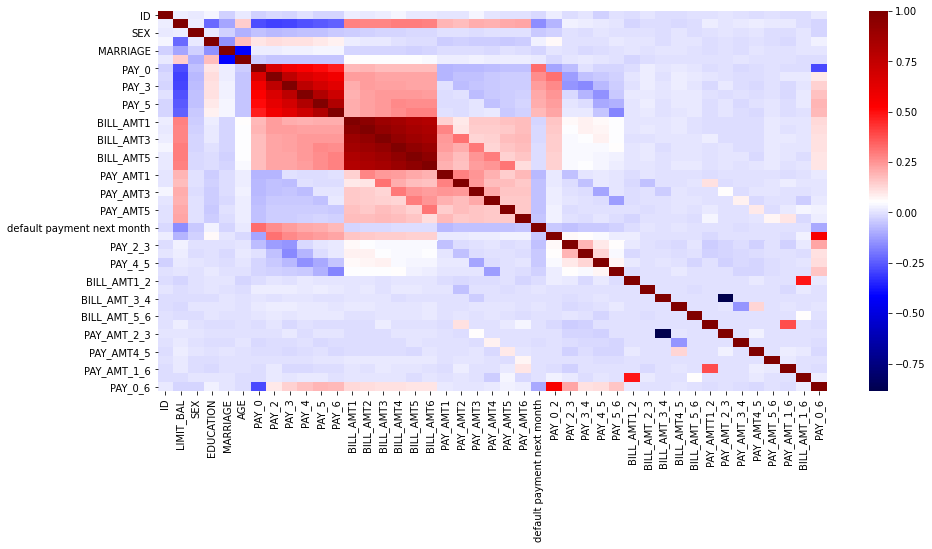

In [10]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), cmap='seismic');

# Modelling

In [11]:
df.drop(columns=["ID"],inplace=True)

In [12]:
y = df["default payment next month"]
X = df.drop(columns=["default payment next month"])

In [13]:
X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 20),scoring="f1"):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid("on")
    return plt

In [15]:
def ROC_plotter(y_train_,y_test_,X_train_,X_test_,estimator):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    fpr, tpr, tresholds = met.roc_curve(y_train_ , estimator.predict_proba(X_train_)[:,1])
    roc_auc = met.roc_auc_score(y_train_ , estimator.predict_proba(X_train_)[:,1])
    plt.plot(fpr, tpr, label='ROC-AUC = %0.2f' % roc_auc, color='darkorange', linestyle='dashdot', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train ')
    plt.legend(loc="lower right")
    plt.subplot(122)
    fpr, tpr, tresholds = met.roc_curve(y_test_ , estimator.predict_proba(X_test_)[:,1] )
    roc_auc = met.roc_auc_score(y_test_ , estimator.predict_proba(X_test_)[:,1])
    plt.plot(fpr, tpr, label='ROC-AUC = %0.2f' % roc_auc, color='darkorange', linestyle='dashdot', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test')
    plt.legend(loc="lower right")
    plt.show()

def PrecisionRecallCurve(y_train_,y_test_,X_train_,X_test_,estimator):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Precision vs Recall Training")
    precision, recall, tresholds = met.precision_recall_curve(y_train_,estimator.predict_proba(X_train_)[:,1])
    plt.plot(tresholds,precision[:-1],"--",color="navy",label="Precison: TP / (TP+FP)")
    plt.plot(tresholds,recall[:-1],"--",color="darkorange",label='Recall: TP / (TP+FN)')
    plt.legend()
    plt.subplot(122)
    plt.title("Precision vs Recall Test")
    precision, recall, tresholds = met.precision_recall_curve(y_test_,estimator.predict_proba(X_test_)[:,1])
    plt.plot(tresholds,precision[:-1],"--",color="navy",label="Precison: TP / (TP+FP)")
    plt.plot(tresholds,recall[:-1],"--",color="darkorange",label='Recall: TP / (TP+FN)')
    plt.legend()
    plt.show()
    
def PrecisionRecallCurve2(y_train_,y_test_,X_train_,X_test_,estimator):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Precision vs Recall Training")
    precision, recall, tresholds = met.precision_recall_curve(y_train_,estimator.predict_proba(X_train_)[:,1])
    pr_auc = met.auc(recall, precision)
    plt.plot(recall,precision,"--",color="darkorange",label='LR (PR-AUC = %0.2f)' % pr_auc)
    no_skill = len(y_train_[y_train_==1]) / len(y_train_)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='No Skill')
    plt.legend()
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.title("precision recall curve")
    plt.subplot(122)
    plt.title("Precision vs Recall Test")
    precision, recall, tresholds = met.precision_recall_curve(y_test_,estimator.predict_proba(X_test_)[:,1])
    pr_auc = met.auc(recall, precision)
    plt.plot(recall,precision,"--",color="darkorange",label='LR (PR-AUC = %0.2f)' % pr_auc)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='No Skill')
    plt.legend()
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()

# RANDOM FOREST

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 39.0min finished



Best CV score: 0.547179 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 6, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2}

Training
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     15654
           1       0.56      0.64      0.60      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.75      0.74     20100
weighted avg       0.82      0.81      0.81     20100

Test
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7710
           1       0.51      0.58      0.54      2190

    accuracy                           0.78      9900
   macro avg       0.69      0.71      0.70      9900
weighted avg       0.80      0.78      0.79      9900



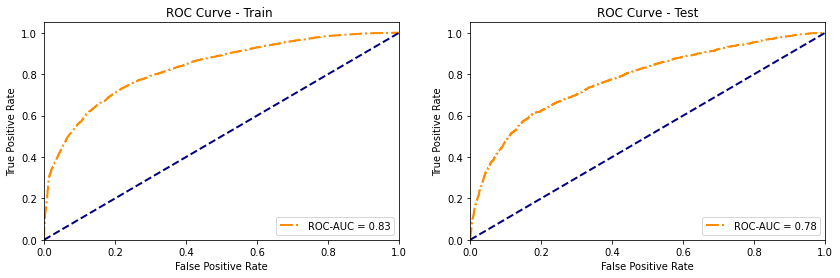

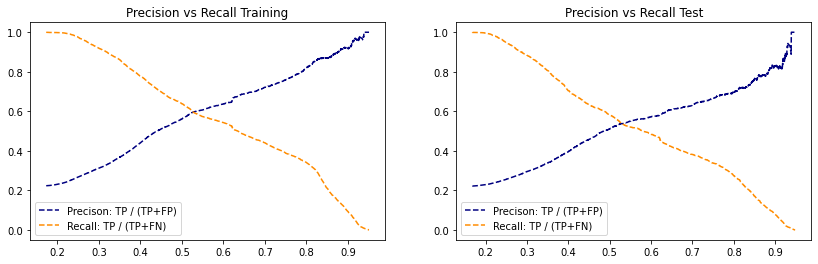

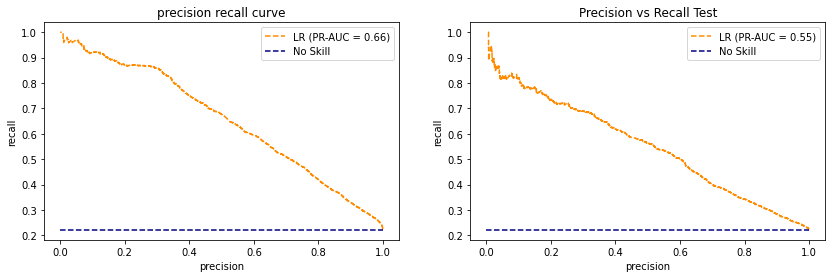

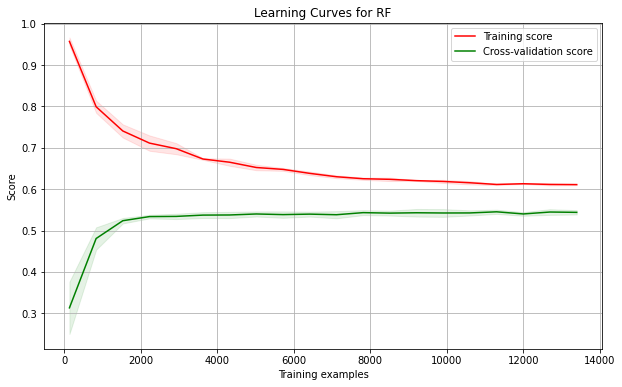

In [19]:
import warnings
warnings.filterwarnings('ignore') 
pipeline = pip.Pipeline(steps=[ #('prep',preprocessor),
                                ('clf', ens.RandomForestClassifier(random_state=42))
                              ])
params = {
    'clf__criterion': ['entropy', 'gini'],
    'clf__max_features': [6,8,10,"auto"],
    'clf__max_depth': [ 8,10],
    'clf__min_samples_leaf': [1,2, 3],
    'clf__min_samples_split': [1,2, 3],
    'clf__class_weight':[ "balance_subsample","balanced",None]}

kfold = mod.StratifiedKFold(n_splits=3,random_state=42)
grid  = mod.GridSearchCV(estimator=pipeline, param_grid=params, cv=kfold, scoring="f1",verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)
print(); print("Best CV score: %f using %s\n" % (grid.best_score_, grid.best_params_))
print("Training")
print(met.classification_report(y_train, grid.predict(X_train)))
print("Test")
print(met.classification_report(y_test, grid.predict(X_test)))
ROC_plotter(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve2(y_train,y_test,X_train,X_test,grid.best_estimator_)
title = 'Learning Curves for RF'
kfold = mod.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(grid.best_estimator_, title, X_train, y_train, cv=kfold)
plt.show()

Feature ranking:
 1.           PAY_0  5 (0.187347)
 2.           PAY_2  6 (0.100723)
 3.           PAY_3  7 (0.083874)
 4.           PAY_4  8 (0.050539)
 5.         PAY_0_6 40 (0.044567)
 6.           PAY_6 10 (0.037862)
 7.         PAY_0_2 23 (0.037761)
 8.           PAY_5  9 (0.032133)
 9.       LIMIT_BAL  0 (0.030737)
10.        PAY_AMT1 17 (0.025331)
11.        PAY_AMT2 18 (0.024564)
12.        PAY_AMT3 19 (0.023572)
13.     BILL_AMT1_2 28 (0.022605)
14.       BILL_AMT1 11 (0.021115)
15.    BILL_AMT_1_6 39 (0.017155)
16.    BILL_AMT_2_3 29 (0.016856)
17.        PAY_AMT6 22 (0.016519)
18.        PAY_AMT5 21 (0.016013)
19.        PAY_AMT4 20 (0.015591)
20.       BILL_AMT2 12 (0.015355)
21.       BILL_AMT3 13 (0.013978)
22.       BILL_AMT4 14 (0.013707)
23.    BILL_AMT_3_4 30 (0.013155)
24.    BILL_AMT_5_6 32 (0.013009)
25.       BILL_AMT6 16 (0.012827)
26.     BILL_AMT4_5 31 (0.012781)
27.       BILL_AMT5 15 (0.012755)
28.     PAY_AMTT1_2 33 (0.010880)
29.             AGE  4 (0.01027

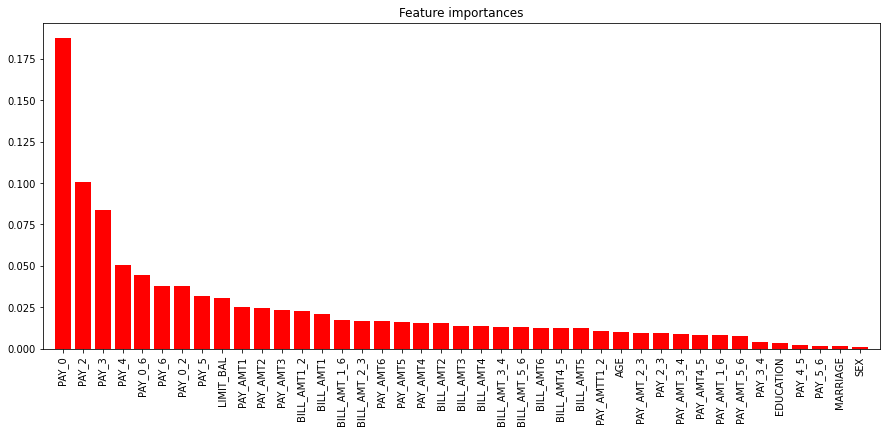

In [20]:
importances = grid.best_estimator_.named_steps["clf"].feature_importances_
std = np.std([grid.best_estimator_.named_steps["clf"].feature_importances_ for tree in  grid.best_estimator_.named_steps["clf"].estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns.tolist()
# Print the feature ranking
print("Feature ranking:")
feature_list = []
for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    feature_list.append(feature_names[indices[f]])
    print("%2d. %15s %2d (%f)" % (f + 1, feature_names[indices[f]], indices[f], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices, rotation='vertical')
plt.xticks(range(X.shape[1]), feature_list, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

The differences bw Training and Test performance in F1, PRAUC and ROCAUC metrics are high. Learning curve shows that model requires more complexity.
I tried a model with regularization but i did not get better results. I will keep them on the notebook. 



# Using RF model with other sampling methods

In [21]:
val = 0.3
import warnings
warnings.filterwarnings('ignore') 
for sampler in [ove.RandomOverSampler(sampling_strategy=val,random_state = 42),ove.SMOTE(sampling_strategy=val,random_state=42), und.RandomUnderSampler(sampling_strategy=val,random_state=42), und.TomekLinks(sampling_strategy="majority"),  com.SMOTEENN(random_state=42)]:
    pipeline = imbPipe.Pipeline([("sampling", sampler),
                                 ('clf', ens.RandomForestClassifier(random_state = 42))])
    params = {
    'clf__criterion': ['entropy'],
    'clf__max_features': [6,8],
    'clf__max_depth': [ 8,6],
    'clf__min_samples_leaf': [1],
    'clf__min_samples_split': [3],
    'clf__class_weight':[ "balance_subsample","balanced",None]}
    kfold = mod.StratifiedKFold(n_splits=3,random_state=42)
    grid  = mod.GridSearchCV(estimator=pipeline, param_grid=params, cv=kfold, scoring="f1",verbose=1,n_jobs=-1)
    grid.fit(X_train,y_train)
    print()
    print("Best CV score: %f using %s\n %s\n" % (grid.best_score_, grid.best_params_,sampler.__class__.__name__))
    pred_train = grid.predict(X_train)
    pred_test = grid.predict(X_test)
    pred_train_p = grid.predict_proba(X_train)
    pred_test_p = grid.predict_proba(X_test)
    print()
    print(sampler.__class__.__name__,"Training")
    print(met.classification_report(y_train, pred_train))
    print(sampler.__class__.__name__,"Test")
    print(met.classification_report(y_test, pred_test))
    print()


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.6min finished



Best CV score: 0.547708 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
 RandomOverSampler


RandomOverSampler Training
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     15654
           1       0.57      0.64      0.60      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.75      0.74     20100
weighted avg       0.82      0.81      0.82     20100

RandomOverSampler Test
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7710
           1       0.51      0.58      0.54      2190

    accuracy                           0.78      9900
   macro avg       0.69      0.71      0.70      9900
weighted avg       0.80      0.78      0.79      9900


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.7min finished



Best CV score: 0.545779 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
 SMOTE


SMOTE Training
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     15654
           1       0.56      0.64      0.60      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.75      0.74     20100
weighted avg       0.82      0.81      0.81     20100

SMOTE Test
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7710
           1       0.51      0.58      0.55      2190

    accuracy                           0.79      9900
   macro avg       0.69      0.71      0.70      9900
weighted avg       0.80      0.79      0.79      9900


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.5min finished



Best CV score: 0.545208 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
 RandomUnderSampler


RandomUnderSampler Training
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     15654
           1       0.56      0.64      0.60      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.75      0.74     20100
weighted avg       0.82      0.81      0.82     20100

RandomUnderSampler Test
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7710
           1       0.51      0.58      0.54      2190

    accuracy                           0.78      9900
   macro avg       0.69      0.71      0.70      9900
weighted avg       0.80      0.78      0.79      9900


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.1min finished



Best CV score: 0.546861 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__max_features': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
 TomekLinks


TomekLinks Training
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     15654
           1       0.52      0.62      0.57      4446

    accuracy                           0.79     20100
   macro avg       0.70      0.73      0.71     20100
weighted avg       0.80      0.79      0.80     20100

TomekLinks Test
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      7710
           1       0.49      0.59      0.54      2190

    accuracy                           0.77      9900
   macro avg       0.69      0.71      0.70      9900
weighted avg       0.79      0.77      0.78      9900


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min finished



Best CV score: 0.542606 using {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
 SMOTEENN


SMOTEENN Training
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     15654
           1       0.56      0.57      0.57      4446

    accuracy                           0.81     20100
   macro avg       0.72      0.72      0.72     20100
weighted avg       0.81      0.81      0.81     20100

SMOTEENN Test
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7710
           1       0.53      0.54      0.54      2190

    accuracy                           0.79      9900
   macro avg       0.70      0.70      0.70      9900
weighted avg       0.79      0.79      0.79      9900




The best model I built is the random forest model with balanced class weights and SMOTE with 55 F1 score. I tried the sampling methods but they gave the similar results.

# XGBoost

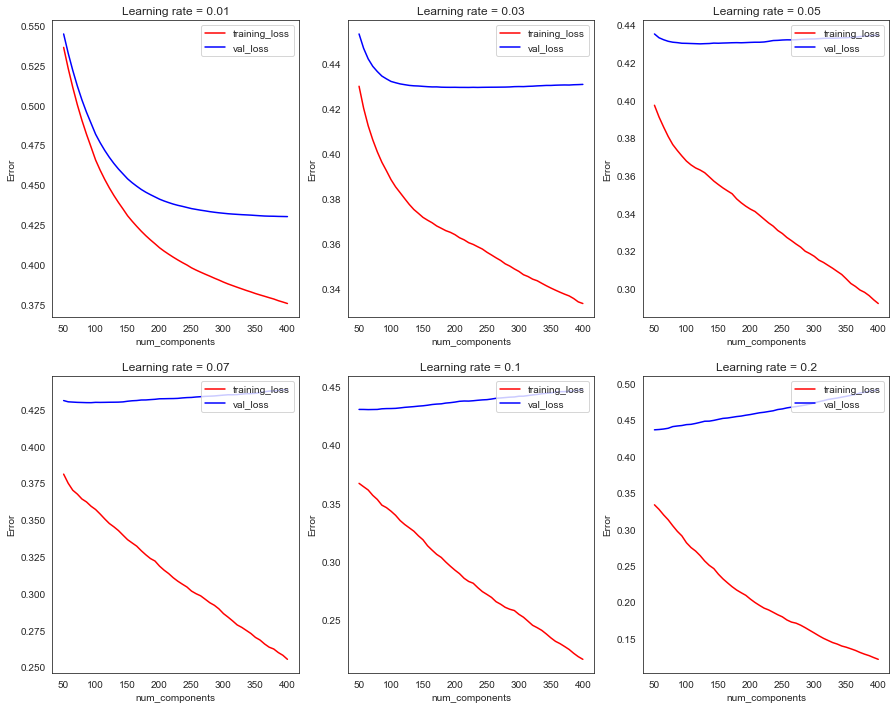

In [ ]:
lrList = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2]
plt.figure(figsize=(15,12))
j = 0
for lr in lrList:
    j += 1 
    trn_loss = [] ; val_loss = []
    for nest in np.linspace(50,400,50, dtype=int):
        clf = XGBClassifier(n_estimators=nest, learning_rate=lr, verbose=0,random_state=42,verbosity=0,use_label_encoder=False,n_jobs=-1)
        clf.fit(X_train, y_train)
        trn_loss.append(met.log_loss(y_train, clf.predict_proba(X_train)))
        val_loss.append(met.log_loss(y_test, clf.predict_proba(X_test)))
    plt.subplot(2,3,j)
    plt.plot(np.linspace(50,400,50), trn_loss, '-r', label='training_loss')
    plt.plot(np.linspace(50,400,50), val_loss, '-b', label='val_loss')
    plt.title("Learning rate = {0}".format(lr))
    plt.ylabel('Error')
    plt.xlabel('num_components')
    plt.legend(loc='upper right')
plt.show()

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best CV score: 0.483976 using {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__min_child_weight': 60, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}

Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.70      0.39      0.50      4446

    accuracy                           0.83     20100
   macro avg       0.78      0.67      0.70     20100
weighted avg       0.81      0.83      0.81     20100

Test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7710
           1       0.67      0.37      0.47      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80      9900



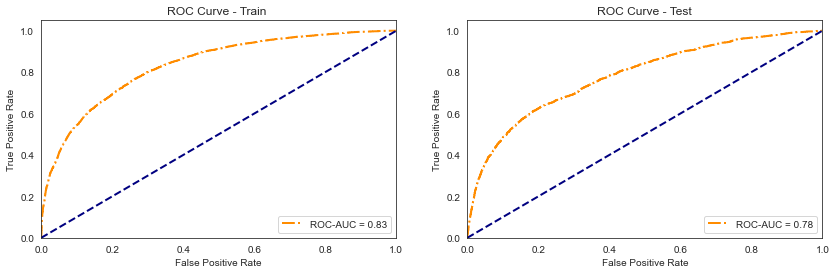

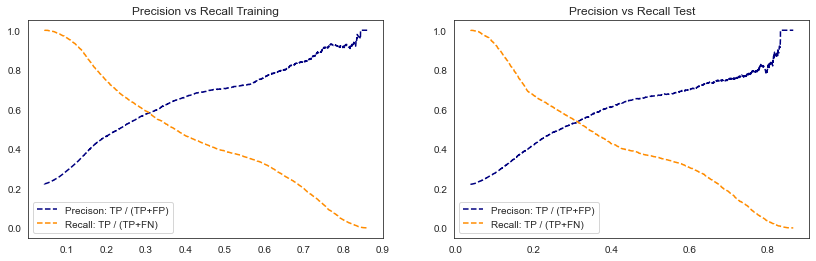

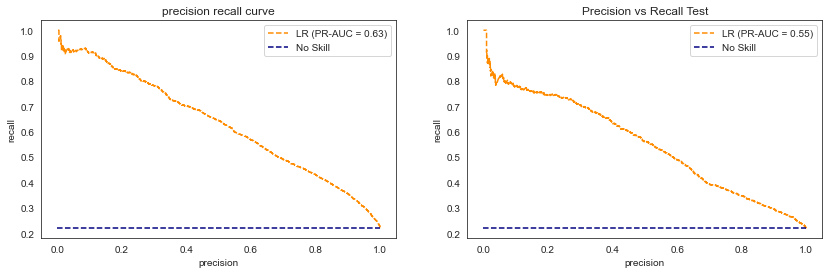

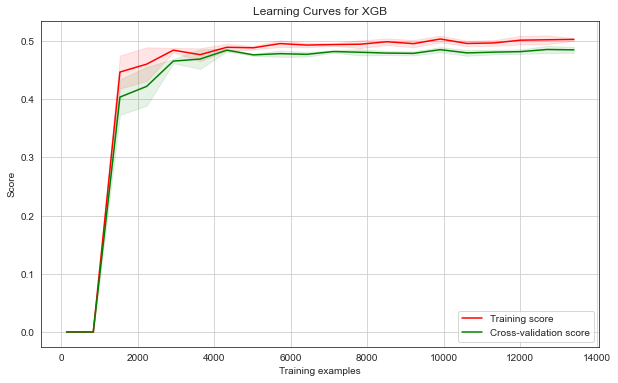

In [ ]:
pipeline = pip.Pipeline(steps=[ #('prep',preprocessor),
                                ('clf', XGBClassifier(verbose=0,random_state=42,verbosity=0,use_label_encoder=False,n_jobs=-1))
                              ])
params = { 
              'clf__learning_rate'    : [0.05],
              'clf__n_estimators'     : [80],
              'clf__max_depth'        : [8,10],
              'clf__min_child_weight' : [50,60,70],
              'clf__gamma'            : [0.5,1,3],
              #'clf__subsample'       : [ 0.9, 1],
              #'clf__colsample_bytree': [ 0.9, 1],
              'clf__reg_alpha'        : [ 1, 3],
              'clf__reg_lambda'       : [ 2, 3]
              #'clf__class_pos_weigh' : [1, 10, 25, 50, 75, 99, 100, 1000,    
              #                         round(((y_train.value_counts().values / y_train.shape[0] ) * 100)[0]),
              #                         round(((y_train.value_counts().values / y_train.shape[0] ) * 100)[1])]
              #'clf__early_stopping_rounds' : [10]
            }

kfold = mod.StratifiedKFold(n_splits=3)
grid  = mod.GridSearchCV(estimator=pipeline, param_grid=params, cv=kfold, scoring="f1",verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)
print(); print("Best CV score: %f using %s\n" % (grid.best_score_, grid.best_params_))
print("Training")
print(met.classification_report(y_train, grid.predict(X_train)))
print("Test")
print(met.classification_report(y_test, grid.predict(X_test)))
ROC_plotter(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve2(y_train,y_test,X_train,X_test,grid.best_estimator_)
title = 'Learning Curves for XGB'
kfold = mod.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(grid.best_estimator_, title, X_train, y_train, cv=kfold)
plt.show()

# Using XGB model with other sampling methods

In [ ]:
X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)
val = 0.3
import warnings
warnings.filterwarnings('ignore') 
for sampler in [ove.RandomOverSampler(sampling_strategy=val,random_state = 42),ove.SMOTE(sampling_strategy=val,random_state=42), und.RandomUnderSampler(sampling_strategy=val,random_state=42), und.TomekLinks(sampling_strategy="majority"),  com.SMOTEENN(random_state=42)]:
    pipeline = imbPipe.Pipeline([("sampling", sampler),
                                 ('clf', XGBClassifier(verbose=0,random_state=42,verbosity=0,use_label_encoder=False,n_jobs=-1))])
    params = { 
              'clf__learning_rate'    : [0.05],
              'clf__n_estimators'     : [80],
              'clf__max_depth'        : [8,10],
              'clf__min_child_weight' : [50,60,70],
              'clf__gamma'            : [0.5,1,3],
              'clf__reg_alpha'        : [1],
              'clf__reg_lambda'       : [3]
            }
    kfold = mod.StratifiedKFold(n_splits=3)
    grid  = mod.GridSearchCV(estimator=pipeline, param_grid=params, cv=kfold, scoring="f1",verbose=1,n_jobs=-1)
    grid.fit(X_train.values,y_train.values)
    print()
    print("Best CV score: %f using %s\n %s\n" % (grid.best_score_, grid.best_params_,sampler.__class__.__name__))
    pred_train = grid.predict(X_train.values)
    pred_test = grid.predict(X_test.values)
    pred_train_p = grid.predict_proba(X_train.values)
    pred_test_p = grid.predict_proba(X_test.values)
    print()
    print(sampler.__class__.__name__,"Training")
    print(met.classification_report(y_train.values, pred_train))
    print(sampler.__class__.__name__,"Test")
    print(met.classification_report(y_test.values, pred_test))
    print()


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.4min finished



Best CV score: 0.486890 using {'clf__gamma': 3, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__min_child_weight': 50, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}
 RandomOverSampler


RandomOverSampler Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.71      0.40      0.51      4446

    accuracy                           0.83     20100
   macro avg       0.78      0.68      0.71     20100
weighted avg       0.82      0.83      0.81     20100

RandomOverSampler Test
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7710
           1       0.66      0.37      0.48      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80      9900


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.5min finished



Best CV score: 0.487939 using {'clf__gamma': 1, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__min_child_weight': 70, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}
 SMOTE


SMOTE Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.70      0.39      0.50      4446

    accuracy                           0.83     20100
   macro avg       0.77      0.67      0.70     20100
weighted avg       0.81      0.83      0.81     20100

SMOTE Test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7710
           1       0.66      0.37      0.47      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80      9900


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.2min finished



Best CV score: 0.487639 using {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 8, 'clf__min_child_weight': 70, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}
 RandomUnderSampler


RandomUnderSampler Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.70      0.39      0.50      4446

    accuracy                           0.83     20100
   macro avg       0.77      0.67      0.70     20100
weighted avg       0.81      0.83      0.81     20100

RandomUnderSampler Test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7710
           1       0.66      0.37      0.47      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.68      9900
weighted avg       0.80      0.82      0.80      9900


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.5min finished



Best CV score: 0.494611 using {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__min_child_weight': 60, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}
 TomekLinks


TomekLinks Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.69      0.41      0.52      4446

    accuracy                           0.83     20100
   macro avg       0.77      0.68      0.71     20100
weighted avg       0.82      0.83      0.81     20100

TomekLinks Test
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7710
           1       0.65      0.39      0.48      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.66      0.69      9900
weighted avg       0.80      0.82      0.80      9900


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  6.2min finished



Best CV score: 0.533146 using {'clf__gamma': 1, 'clf__learning_rate': 0.05, 'clf__max_depth': 8, 'clf__min_child_weight': 60, 'clf__n_estimators': 80, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3}
 SMOTEENN


SMOTEENN Training
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15654
           1       0.50      0.62      0.55      4446

    accuracy                           0.78     20100
   macro avg       0.69      0.72      0.70     20100
weighted avg       0.80      0.78      0.79     20100

SMOTEENN Test
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      7710
           1       0.47      0.60      0.53      2190

    accuracy                           0.76      9900
   macro avg       0.67      0.70      0.68      9900
weighted avg       0.79      0.76      0.77      9900




Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 112.4min finished



Best CV score: 0.483245 using {'clf__gamma': 0.5, 'clf__learning_rate': 0.05, 'clf__max_depth': 8, 'clf__min_child_weight': 100, 'clf__n_estimators': 80}

Training
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15654
           1       0.71      0.39      0.50      4446

    accuracy                           0.83     20100
   macro avg       0.78      0.67      0.70     20100
weighted avg       0.82      0.83      0.81     20100

Test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7710
           1       0.67      0.36      0.47      2190

    accuracy                           0.82      9900
   macro avg       0.75      0.65      0.68      9900
weighted avg       0.80      0.82      0.80      9900



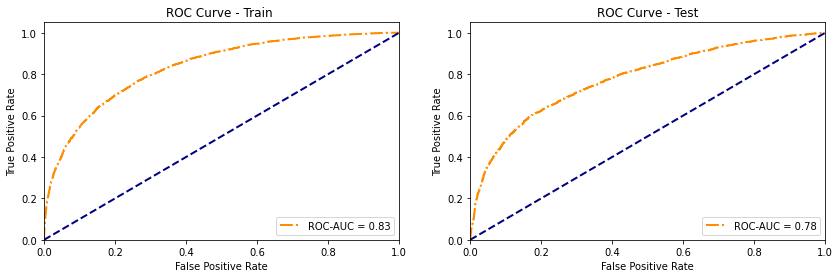

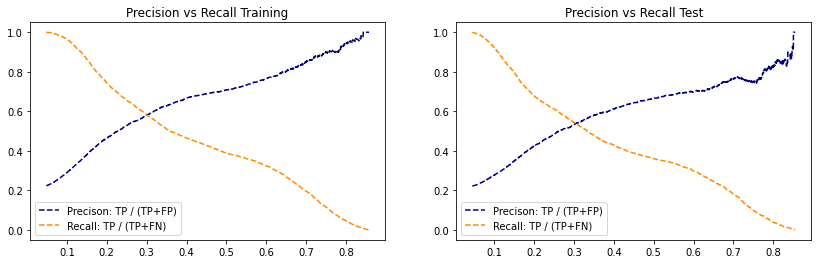

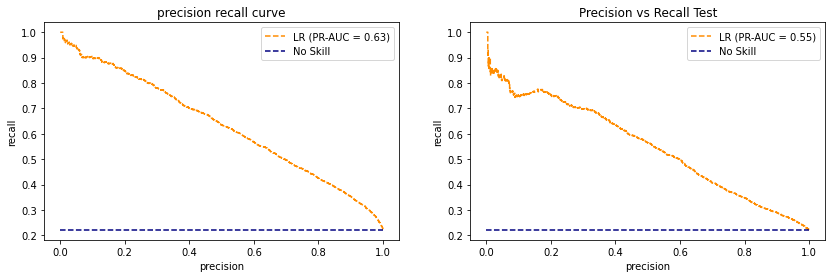

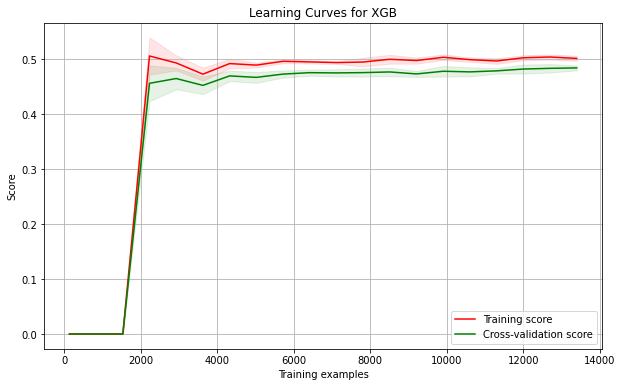

In [ ]:
pipeline = pip.Pipeline(steps=[ #('prep',preprocessor),
                                ('poly',pre.PolynomialFeatures(degree=2)),
                                ('clf', XGBClassifier(verbose=0,random_state=42,verbosity=1,use_label_encoder=False,n_jobs=-1))
                              ])
params = { 
              'clf__learning_rate'    : [0.05],
              'clf__n_estimators'     : [80],
              'clf__max_depth'        : [8,10],
              'clf__min_child_weight' : [50,60,70,100],
              'clf__gamma'            : [0.5,1,3,10],
              #'clf__subsample'       : [ 0.9, 1],
              #'clf__colsample_bytree': [ 0.9, 1],
              #'clf__reg_alpha'        : [ 1, 3],
              #'clf__reg_lambda'       : [ 2, 3]
              #'clf__class_pos_weigh' : [1, 10, 25, 50, 75, 99, 100, 1000,    
              #                         round(((y_train.value_counts().values / y_train.shape[0] ) * 100)[0]),
              #                         round(((y_train.value_counts().values / y_train.shape[0] ) * 100)[1])]
              #'clf__early_stopping_rounds' : [10]
            }

kfold = mod.StratifiedKFold(n_splits=3)
grid  = mod.GridSearchCV(estimator=pipeline, param_grid=params, cv=kfold, scoring="f1",verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)
print(); print("Best CV score: %f using %s\n" % (grid.best_score_, grid.best_params_))
print("Training")
print(met.classification_report(y_train, grid.predict(X_train)))
print("Test")
print(met.classification_report(y_test, grid.predict(X_test)))
ROC_plotter(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve(y_train,y_test,X_train,X_test,grid.best_estimator_)
PrecisionRecallCurve2(y_train,y_test,X_train,X_test,grid.best_estimator_)
title = 'Learning Curves for XGB'
kfold = mod.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(grid.best_estimator_, title, X_train, y_train, cv=kfold)
plt.show()